# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data (NBA_Perf_22 and nba_salaries_22), merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


# Drop variables that will not be needed or are duplicates

In [24]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# loading the dataset

Salaries = pd.read_csv('2025_salaries (1) 2.csv',header=0, sep=",", encoding='latin-1')
Stats = pd.read_csv('nba_2025.txt', sep=",", encoding='latin-1')

In [28]:
# merging the datasets

Merged = pd.merge(Salaries, Stats, on='Player', how='inner')
Merged.head()


,Player,Tm,Salary 20205,Rk,Age,Team,Pos,G,GS,MP,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,Garrison Mathews,IND,"$131,970.00",398.0,29.0,IND,SG,15.0,1.0,196.0,...,17.0,10.0,6.0,3.0,3.0,19.0,78.0,0.0,NaN,mathega01
1,Garrison Mathews,IND,"$131,970.00",398.0,29.0,IND,SG,15.0,1.0,196.0,...,17.0,10.0,6.0,3.0,3.0,19.0,78.0,0.0,NaN,mathega01
2,Mac McClung,IND,"$164,060.00",459.0,27.0,2TM,SG,4.0,0.0,47.0,...,5.0,2.0,5.0,2.0,3.0,8.0,23.0,0.0,NaN,mccluma01
3,Mac McClung,IND,"$164,060.00",459.0,27.0,IND,SG,3.0,0.0,34.0,...,4.0,1.0,5.0,1.0,2.0,6.0,19.0,0.0,NaN,mccluma01
4,Mac McClung,IND,"$164,060.00",459.0,27.0,CHI,SG,1.0,0.0,13.0,...,1.0,1.0,0.0,1.0,1.0,2.0,4.0,0.0,NaN,mccluma01


In [31]:
# Dropping unnecessary duplicate

Merged_nodupes = Merged.drop_duplicates(subset=['Player'], keep='first')

# dropping colums that are not needed (Rk, Age, Team, Pos, G, GS, Trp-Dbl, Awards, Player-additional)

Merged_clean = Merged_nodupes.drop(columns=['Rk', 'Age', 'Team', 'Pos', 'G', 'GS', 'Trp-Dbl', 'Awards', 'Player-additional'])


In [53]:
# Creating a threshold for player minutes (must have played two thirds of the median minutes played by all players)
min_minutes = Merged_clean['MP'].median() * (2/3)
Merged_restricted = Merged_clean[Merged_clean['MP'] >= min_minutes]

# Creating shooting score (making sure there is a weight to value shooting 50% on 1000 attempts more than shooting 50% on 100 attempts)

import numpy as np

def weighted_pct(made, att, k):
    pct = np.where(att > 0, made / att, 0.0)
    vol = att / (att + k)
    return pct * vol

# Showing that shooting over median attempts is more valuable than shooting under(so 50% on 1000 attempts is more impressive than 50% on 100 attempts)
k3  = Merged_restricted["3PA"].median()
k2  = Merged_restricted["2PA"].median()
kft = Merged_restricted["FTA"].median()

Merged_restricted["w3"]  = weighted_pct(Merged_restricted["3P"], Merged_restricted["3PA"], k3)
Merged_restricted["w2"]  = weighted_pct(Merged_restricted["2P"], Merged_restricted["2PA"], k2)
Merged_restricted["wft"] = weighted_pct(Merged_restricted["FT"], Merged_restricted["FTA"], kft)

Merged_restricted["ShootingScore"] = 3*Merged_restricted["w3"] + 2*Merged_restricted["w2"] + 1*Merged_restricted["wft"]

# Creating a net impact score, all positive stats weighted then taking out turnovers
Merged_restricted["NetImpact"] = (
    2.5 * Merged_restricted["AST"]
    + 1.2 * Merged_restricted["ORB"]
    + 0.8 * Merged_restricted["DRB"]
    + 2.0 * Merged_restricted["STL"]
    + 1.2 * Merged_restricted["BLK"]
    - 2.0 * Merged_restricted["TOV"]
)

# My version of player efficiency with available stats
Merged_restricted["FinalEfficiency"] = (
    (Merged_restricted["ShootingScore"] + Merged_restricted["NetImpact"])
    / Merged_restricted["MP"]
)

# fixing the salary column so it can be used in the clustering algorithm
Merged_restricted[" Salary 20205"] = Merged_restricted[" Salary 20205"].replace('[\$,]', '', regex=True).astype(float)

<>:42: SyntaxWarning: invalid escape sequence '\$'
<>:42: SyntaxWarning: invalid escape sequence '\$'
/var/folders/19/rdtdwbss25g5vyf8hc0qfz7r0000gn/T/ipykernel_26941/623296124.py:42: SyntaxWarning: invalid escape sequence '\$'
  Merged_restricted[" Salary 20205"] = Merged_restricted[" Salary 20205"].replace('[\$,]', '', regex=True).astype(float)


# Run the clustering algo with your best guess for K



In [ ]:
# running with cluster of 5
mymodel = KMeans(n_clusters= 5, random_state=42)

# Creating X

X = Merged_restricted[["FinalEfficiency", " Salary 20205"]]

#Scaling the data

Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

# Fitting the model
mymodel.fit(X_scaled)

# Adding the cluster labels to the original dataframe
Merged_restricted["Cluster"] = mymodel.fit_predict(X_scaled)



# View the results



In [69]:
# Viewing the results
Merged_restricted[["Player", "FinalEfficiency", " Salary 20205", "Cluster"]].head()

,Player,FinalEfficiency,Salary 20205,Cluster
12,Will Richard,0.344372,1272870.0,2
14,Micah Peavy,0.358170,1272870.0,2
17,Maxime Raynaud,0.348639,1272870.0,2
20,Pelle Larsson,0.441820,1955377.0,0
21,Adem Bona,0.317465,1955377.0,2


# Create a visualization of the results with 2 or 3 variables that you think will best differentiate the clusters



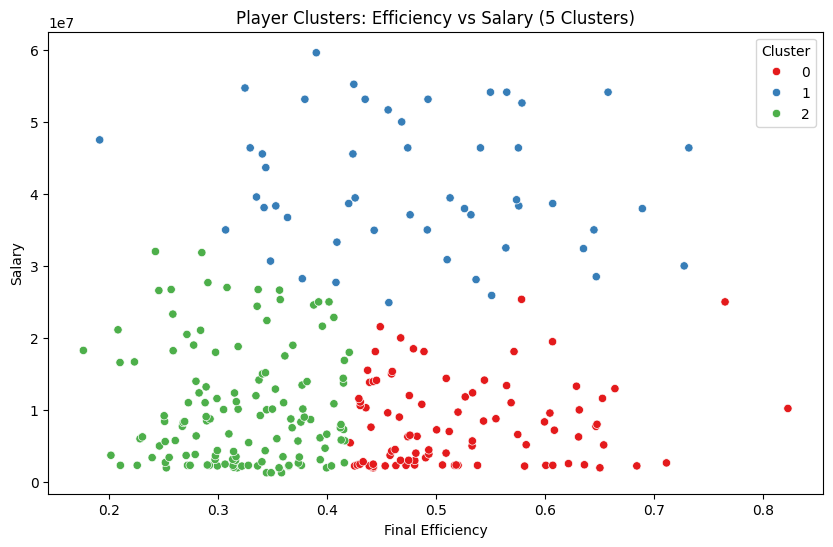

In [90]:
# creating scatterplot to visualize the clusters

plt.figure(figsize=(10, 6))

sns.scatterplot(data=Merged_restricted, x="FinalEfficiency", y=" Salary 20205", hue="Cluster", palette="Set1")
plt.title("Player Clusters: Efficiency vs Salary (5 Clusters)")
plt.xlabel("Final Efficiency")
plt.ylabel("Salary")
plt.show()

# Evaluate the quality of the clustering using total variance explained and silhouette scores

In [ ]:
# Evaluating the quality of the clusters with silhouette score

Sil_Score = silhouette_score(X_scaled, Merged_restricted["Cluster"])
print(Sil_Score)

# Total variance explained by the clusters
print(mymodel.inertia_)

# Based on the silhouette score, the clusters are only moderatly well defined, whcich could make sense given the complexity of the data used. What it shows is that it is somewhat seperated and that is usable but not perfect. With the inertia lower is betteras it gives the total within cluster sum of squares but it is hard to know what a good score is without comparing it to more clusters.

0.39554032257926497
126.38885111007306


# Determine the ideal number of clusters using the elbow method and the silhouette coefficient

In [ ]:
# finding ideal number of clusters with elbow method and silhouette score

inertia = []
silhouette_scores = []
K_range = range(2, 15)

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, model.labels_))
for k, inert, sil in zip(K_range, inertia, silhouette_scores):
    print(f"K={k}: Inertia={inert:.2f}, Silhouette={sil:.3f}")


# Based off the elbow method, it looks like 3 would be a good number of clusters as the silhouette score is high and the inertia is lowering and is a clear elbow point which is what we are testing. This should be able to provide us with the most undervalued players.

K=2: Inertia=329.21, Silhouette=0.470
K=3: Inertia=192.46, Silhouette=0.421
K=4: Inertia=148.58, Silhouette=0.423
K=5: Inertia=126.39, Silhouette=0.396
K=6: Inertia=94.47, Silhouette=0.408
K=7: Inertia=82.74, Silhouette=0.392
K=8: Inertia=72.20, Silhouette=0.394
K=9: Inertia=63.15, Silhouette=0.358
K=10: Inertia=59.44, Silhouette=0.355
K=11: Inertia=52.50, Silhouette=0.378
K=12: Inertia=49.03, Silhouette=0.347
K=13: Inertia=45.02, Silhouette=0.346
K=14: Inertia=40.36, Silhouette=0.375


# Visualize the results of the elbow method

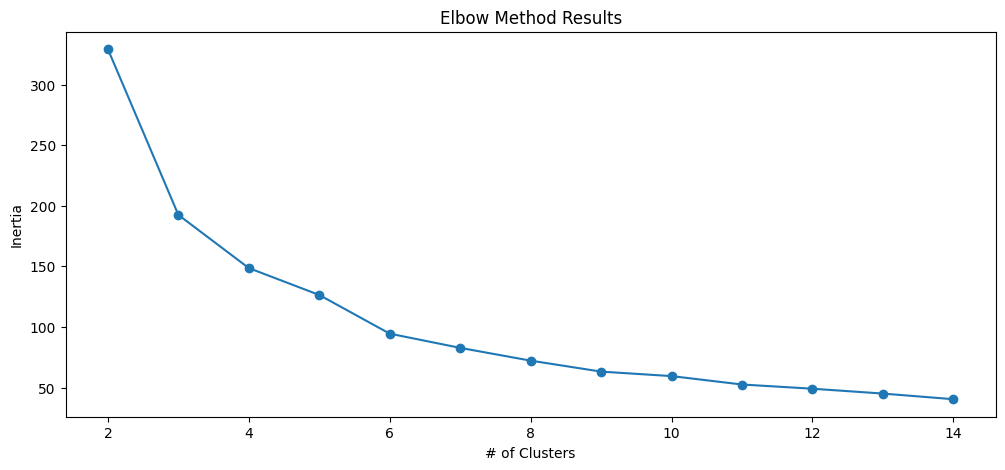

In [82]:
# Elbow method plot

plt.figure(figsize=(12, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method Results')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.show()

# Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

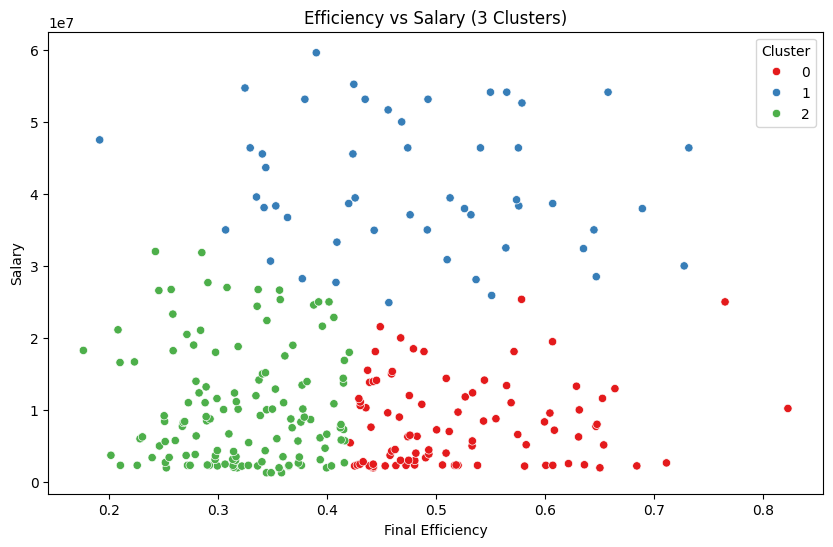

In [91]:
# running with cluster of 3
mymodel = KMeans(n_clusters= 3, random_state=42)

# Creating X

X = Merged_restricted[["FinalEfficiency", " Salary 20205"]]

#Scaling the data

Scaler = StandardScaler()
X_scaled = Scaler.fit_transform(X)

# Fitting the model
mymodel.fit(X_scaled)

# Adding the cluster labels to the original dataframe
Merged_restricted["Cluster"] = mymodel.fit_predict(X_scaled)

# Viewing the results
Merged_restricted[["Player", "FinalEfficiency", " Salary 20205", "Cluster"]].head()

plt.figure(figsize=(10, 6))

sns.scatterplot(data=Merged_restricted, x="FinalEfficiency", y=" Salary 20205", hue="Cluster", palette="Set1")
plt.title("Efficiency vs Salary (3 Clusters)")
plt.xlabel("Final Efficiency")
plt.ylabel("Salary")
plt.show()




# Once again evaluate the quality of the clustering using total variance explained and silhouette scores

In [84]:
Sil_Score = silhouette_score(X_scaled, Merged_restricted["Cluster"])
print(Sil_Score)

# Total variance explained by the clusters
print(mymodel.inertia_)

0.42069594964464757
192.4649426237354


# Use the model to select players for Mr. Rooney to consider

In [89]:
# Finding players in the correct cluster

Cluster_0_players = Merged_restricted[Merged_restricted["Cluster"] == 0][["Player", "FinalEfficiency", " Salary 20205"]]
print(Cluster_0_players)

# Based off the results we can see that there is a total of 92 different players that are deemed to be undervalued based on their currenet efficiency and salary. To list a few, Naz Reid, Jarrett Allen, and Jaren Jackson Jr are some of the players that I've found




               Player  FinalEfficiency   Salary 20205
20      Pelle Larsson         0.441820      1955377.0
34       Oso Ighodaro         0.442419      1955377.0
35        Jamal Shead         0.650543      1955377.0
41   Precious Achiuwa         0.442468      2111516.0
44        Tyler Kolek         0.581372      2191897.0
..                ...              ...            ...
414         Josh Hart         0.607035     19472240.0
416     Jarrett Allen         0.467596     20000000.0
420          Naz Reid         0.448833     21551724.0
432       Josh Giddey         0.765461     25000000.0
435       Nic Claxton         0.578586     25352272.0

[92 rows x 3 columns]


# Write up the results in a separate notebook with supporting visualizations and an overview of how and why you made the choices you did. This should be at least 500 words and should be written for a non-technical audience.